# How to avoid a Pandas pandemonium
## A deep dive into Pandas best practices using self-contained examples

When you first start out using Pandas, it's often best to just get your feet wet and deal with problems as they come up. Then, the years pass, the amazing things you've been able to build with it start to accumulate, but you have a vague inkling that you keep making the same kinds of mistakes and that your code is running really slowly for what seems like pretty simple operations. This is when it's time to dig into the inner workings of Pandas and take your code to the next level. Like with any library, the best way to optimize your code is to understand what's going on underneath the syntax.

## Topics
* Writing good code
* Common silent failures
* Speeding up your runtime
* Lowering your memory footprint

In [1]:
# for neatness, it helps to keep all of your imports up top
import sys
import traceback
import numba
import numpy as np
import pandas as pd
import numpy.random as nr
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
# generate some fake data to play with
data = {
    "day_of_week": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] * 1000,
    "booleans": [True, False] * 3500,
    "positive_ints": nr.randint(0, 100, size=7000),
    "mixed_ints": nr.randint(-100, 100, size=7000),
    "lat1": nr.randn(7000) * 30,
    "lon1": nr.randn(7000) * 30,
    "lat2": nr.randn(7000) * 30,
    "lon2": nr.randn(7000) * 30,
}

df_large = pd.DataFrame(data)

In [3]:
df_large.head()

,day_of_week,booleans,positive_ints,mixed_ints,lat1,lon1,lat2,lon2
0,Monday,True,42,79,5.745216,-43.094330,15.617175,-24.790654
1,Tuesday,False,52,-30,-18.486213,19.586532,17.345942,56.579815
2,Wednesday,True,44,-69,3.417936,-33.305177,20.157805,-25.048502
3,Thursday,False,64,-9,-31.167047,-37.542818,-11.478706,-55.032297
4,Friday,True,6,-31,21.443933,-33.310642,-63.551866,33.354095


In [4]:
small = {
    'a': [1, 1],
    'b': [2, 2]
}

df_small = pd.DataFrame(small)

df_small

,a,b
0,1,2
1,1,2


## Writing good code
Before we do the "cool" stuff like writing faster and more memory-optimized code, we need to do it on a foundation of some fairly mundane-seeming coding best practices. These are the little things, such as naming things expressively and writing sanity checks, that will help keep your code maintainable and readable by your peers. 

### Sanity checking is simple and totally worth it

Just because this is mostly just data analysis, and it might not make sense to put up a whole suite of unit tests for it, doesn't mean you can't do any kind of checks at all. Peppering your notebook code with `assert` can go a long way without much extra work. 

Above, we made a DataFrame `df_large` that contains numbers with some pre-defined rules. For example, you can check for data entry errors by trimming whitespace and checking that the number of entries stays the same:

In [5]:
large_copy = df_large.copy()

In [6]:
assert large_copy["day_of_week"].str.strip().unique().size == large_copy["day_of_week"].unique().size

In [7]:
large_copy.loc[0, "day_of_week"] = "Monday "

assert large_copy["day_of_week"].str.strip().unique().size == large_copy["day_of_week"].unique().size

AssertionError: 

### Use consistent indexing

Pandas grants you a lot of flexibility in indexing, but it can add up to a lot of confusion later if you're not disciplined about keeping a consistent style. This is one proposed standard (followed by some examples of indexing that technically produce the same effect):

In [8]:
# for getting columns, use a string or a list of strings for multiple columns
# note: a one-column DataFrame and a Series are not the same thing
one_column_series = df_large["mixed_ints"]
two_column_df = df_large[["mixed_ints", "positive_ints"]]

# for getting a 2D slice of data, use `loc`
data_view_series = df_large.loc[:10, "positive_ints"]
data_view_df = df_large.loc[:10, ["mixed_ints", "positive_ints"]]

# for getting a subset of rows, also use `loc`
row_subset_df = df_large.loc[:10, :]

In [9]:
# here's some alternatives for the above
# one way is to use `df.loc` for everything, but it can look clunky
one_column_series = df_large.loc[:, "mixed_ints"]
two_column_df = df_large.loc[:, ["mixed_ints", "positive_ints"]]

# you can use `iloc`, which is `loc` but with indexes, but it's not as clear
# also, you're in trouble if you ever change the column order
data_view_series = df_large.iloc[:10, 2]
data_view_df = df_large.iloc[:10, [3, 2]]

# you can get rows like you slice a list, but this can be confusing
row_subset_df = df_large[:10]

# why confusing? because df_large[10] actually gives you column 10, not row 10

### But don't use chained indexing
What is chained indexing? It's when you separately index the columns and the rows, which will make two separate calls to `__getitem__()` (or worse, one call to `__getitem__()` and one to `__setitem__()` if you're making assignments, which we demonstrate below). It's not so bad if you're just indexing and not making assignments, but it's still not ideal from a readability standpoint because if you index the rows in one place and then index a column, unless you're very disciplined about variable naming, it's easy to lose track of what exactly you indexed.

In [10]:
data_view_series = df_large[:10]["mixed_ints"]
data_view_df = df_large[:10][["mixed_ints", "positive_ints"]]

# this is also chained indexing, but low-key
row_subset_df = df_large[:10]
data_view_df = row_subset_df[["mixed_ints", "positive_ints"]]

## Common silent failures
Even if you do all of the above, sometimes Pandas' flexibility can lull you into making mistakes that don't actually make you error out. These are particularly pernicious because you often don't realize something is wrong until something far downstream doesn't make sense, and it's very hard to trace back to what the cause was.

### View vs. Copy
A view and a copy of a DataFrame can look identical to you in terms of the values it contains, but a view references a piece of an existing DataFrame and a copy is a whole different DataFrame. If you change a view, you change the existing DataFrame, but if you change a copy, the original DataFrame is unaffected. Make sure you aren't modifying a view when you think you're modifying a copy and vice versa.

It turns out that whether you're dealing with a copy or a view is very difficult to predict! Internally, Pandas tries to optimize by returning a view or a copy depending on the DataFrame and the actions you take. You can force Pandas to make a copy for you by using `df.copy()` and you can force Pandas to operate in place on a DataFrame by setting `inplace=true` when it's available.

When to make a copy and when to use a view? It's hard to say for sure, but if your data is small or your resources are large and you want to go functional and stateless, you can try making a copy for every operation, like Spark would, since it's probably the safest way to do things. On the other hand, if you have lots of data and a regular laptop, you might want to operate in place to prevent your notebooks from crashing.

In [11]:
# intentionally making a copy will always make a copy
small_copy = df_small.copy()

small_copy

,a,b
0,1,2
1,1,2


In [12]:
# seeing `inplace=true` in the API reference means you have a choice to make a copy or not
small_drop = small_copy.drop("b", axis=1)

small_drop

,a
0,1
1,1


In [13]:
# if you don't assign to anything when `inplace=False` (default), the operation doesn't affect the input
small_copy.drop("b", axis=1)

small_copy

,a,b
0,1,2
1,1,2


In [14]:
# if you do set `inplace=True`, the same operation will actually alter the input
# fun fact: setting `inplace=True` will cause this to return `None` instead of a DataFrame
small_copy.drop("b", axis=1, inplace=True)

small_copy

,a
0,1
1,1


In [15]:
# let's see what happens if you assign to a copy
small_copy = df_small.copy()

# you should always use `loc` for assignment
small_copy.loc[0, 'b'] = 4

small_copy

,a,b
0,1,4
1,1,2


In [16]:
# original is unchanged - this is why making copies is handy
df_small

,a,b
0,1,2
1,1,2


In [17]:
# do not use chained indexing for assignment
small_copy[:1]['b'] = 4

/Users/pamelawu/.virtualenvs/link/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Watch out for out of order processing
In Jupyter notebooks, it's almost unavoidable to change and re-process cells out of order - we know we shouldn't do it, but it always ends up happening. This is a subset of the view vs. copy problem because if you know that you're making a change that fundamentally alters the properties of a column, you should eat the memory cost and make a new copy, or something like this might happen where you run the latter two cells in this block over and over and see the max value get pretty unstable.

In [18]:
large_copy = df_large.copy()

In [55]:
large_copy.loc[0, "positive_ints"] = 120

large_copy["positive_ints"].max()

2673

In [56]:
large_copy["positive_ints"] = large_copy["positive_ints"] * 3

large_copy["positive_ints"].max()

8019

### Never set errors to "ignore"
Some Pandas methods allow you to ignore errors by default. This is almost always a bad idea because ignoring errors means it just puts your unparsed input in place of where the output should have been. Note in the following example that if you were not overly familiar with what Pandas outputs should be, seeing an output of `array` type might not seem that unusal to you, and you  might just move on with your analysis, not knowing that something had gone wrong.

In [21]:
parsed_dates = pd.to_datetime(["10/11/2018", "01/30/1996", "04/15/9086"], format="%m/%d/%Y", errors="ignore")

parsed_dates

array(['10/11/2018', '01/30/1996', '04/15/9086'], dtype=object)

In [22]:
# suppressing this error because it's very large!
try:
    pd.to_datetime(["10/11/2018", "01/30/1996", "04/15/9086"], format="%m/%d/%Y")
except Exception:
    traceback.print_exc(limit=1)

Traceback (most recent call last):
  File "/Users/pamelawu/.virtualenvs/link/lib/python3.6/site-packages/pandas/core/tools/datetimes.py", line 377, in _convert_listlike
    values, tz = conversion.datetime_to_datetime64(arg)
TypeError: Unrecognized value type: <class 'str'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-22-12145c38fd6e>", line 3, in <module>
    pd.to_datetime(["10/11/2018", "01/30/1996", "04/15/9086"], format="%m/%d/%Y")
pandas._libs.tslibs.np_datetime.OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 9086-04-15 00:00:00


In [23]:
# when the offending timestamp is removed, this is what the output is supposed to look like
pd.to_datetime(["10/11/2018", "01/30/1996"], format="%m/%d/%Y")

DatetimeIndex(['2018-10-11', '1996-01-30'], dtype='datetime64[ns]', freq=None)

### The `object` dtype can hide mixed types
Each Pandas column has a type, but there is an uber-type called `object`, which means each value is actually just a pointer to some arbitrary object. This allows Pandas to have a great deal of flexibility (i.e. columns of lists or dictionaries or whatever you want!), but it can result in silent fails. 

**Spoiler alert:** this won't be the first time `object` type causes us problems. I don't want to say you shouldn't use it, but once you're in production mode, you should definitely use it with caution.

In [24]:
# we start out with integer types for our small data
small_copy = df_small.copy()

small_copy.dtypes

a    int64
b    int64
dtype: object

In [25]:
# reset ones of the column's dtype to `object`
small_copy["b"] = small_copy["b"].astype("object")

small_copy.dtypes

a     int64
b    object
dtype: object

In [26]:
# now let's set ourselves up for a problem
small_copy["b"] = [4, "4"]

small_copy

,a,b
0,1,4
1,1,4


In [27]:
# the unmodified column behaves as expected
small_copy.drop_duplicates("a")

,a,b
0,1,4


In [28]:
# not only is this not what you wanted, but it would be totally buried in the data
small_copy.drop_duplicates("b")

,a,b
0,1,4
1,1,4


### Tread carefully with Pandas schema inference
When you load in a big, mixed-type CSV and Pandas gives you the option to set `low_memory=False` when it encounters some data it doesn't know how to handle, what it's actually doing is just making that entire column `object` type so that the numbers it can convert to `int64` or `float64` get converted, but the stuff it can't convert just sit there as `str`. This makes the column values able to peacefully co-exist, for now. But once you try to do any operations on them, you'll see that Pandas was just trying to tell you all along that you can't assume all the values are numeric.

**Note:** Remember, in Python, `NaN` is a `float`! So if your numeric column has them, cast them to `float` even if they're actually `int`.

In [29]:
mixed_df = pd.DataFrame({"mixed": [100] * 100 + ["-"] + [100] * 100, "ints": [100] * 201})

mixed_df.to_csv("test_load.csv", header=True, index=False)

In [30]:
mixed_df = pd.read_csv("test_load.csv", header=0)

mixed_df.dtypes

mixed    object
ints      int64
dtype: object

In [31]:
# the best practices way is to specify schema and properly set your null values
mixed_df = pd.read_csv("test_load.csv", header=0, dtype={"mixed": float, "ints": int}, na_values=["-"])

mixed_df.dtypes

mixed    float64
ints       int64
dtype: object

## Speeding up
Now that you have great coding habits, it's time to try to up the performance. There's a range of things you can use, from vectorization to just-in-time compilation to get your code running faster. To measure bottlenecks and quantify performance gains, let's introduce `timeit`, a nifty Jupyter notebook tool for performance measurement. All you need to know is that putting `%timeit` before a single line of code will measure the runtime of that line, while putting `%%timeit` in a code block will measure the runtime for the whole block.

In [32]:
# example taken from StackOverflow: https://bit.ly/2V2UZYr
def haversine(lat1, lon1, lat2, lon2):
    """Haversine calculates the distance between two points on a sphere."""
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    return c

In [33]:
%%timeit

haversine(100, -100, 50, -50)

14.3 µs ± 308 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [34]:
large_copy = df_large.copy()

### Choosing the right way to iterate through rows

In [35]:
%%timeit

# `iterrows` is a generator that yields indices and rows
dists = []
for i, r in large_copy.iterrows():
    dists.append(haversine(r["lat1"], r["lon1"], r["lat2"], r["lon2"]))

large_copy["spherical_dist"] = dists

736 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit

# a somewhat optimized way that borrows from functional programming
large_copy["spherical_dist"] = large_copy.apply(
    lambda r: haversine(r["lat1"], r["lon1"], r["lat2"], r["lon2"]), axis=1
)

387 ms ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
# using vectorization is about 100-300X faster for this operation
%timeit large_copy["spherical_dist"] = haversine(\
    large_copy["lat1"], \
    large_copy["lon1"], \
    large_copy["lat2"], \
    large_copy["lon2"] \
)

2.17 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Some rules of thumb for iterating
Like with indexing, Pandas is flexible about how you want to go through the values of each row. The following are some rules of thumb:
* If you want to apply the same transformation to each value of of a column, you should use vectorization.
    * If you need conditional vectorization, use boolean indexing
    * Also works on strings! i.e. `Series.str.replace("remove_word", "")`
* You should only use `apply` for specific functions that can't be broadcast. i.e. `pd.to_datetime`
* It's hard to think of valid use case examples for `iterrows`, probably because the only valid use cases are so complicated and situation-specific that they don't make good didactic examples.

### Boolean indexing, what's that again?
You probably don't need this reminder, but just in case, boolean indexing is a way of vectorizing indexing where you convert the index into a series of `True` and `False` values, and when you apply the index to a column or DataFrame, the values that get selected are the ones where the boolean index was `True`. 

In [38]:
mondays = large_copy["day_of_week"] == "Monday"

mondays.head()

0     True
1    False
2    False
3    False
4    False
Name: day_of_week, dtype: bool

In [39]:
large_copy.loc[mondays, :].head()

,day_of_week,booleans,positive_ints,mixed_ints,lat1,lon1,lat2,lon2,spherical_dist
0,Monday,True,42,79,5.745216,-43.094330,15.617175,-24.790654,0.357681
7,Monday,False,18,24,3.998923,-35.926048,-15.603738,13.337621,0.916955
14,Monday,True,88,-67,-19.885387,-29.692172,-18.729195,4.747911,0.566669
21,Monday,False,58,-72,33.824496,-4.376150,-11.513267,17.162267,0.868354
28,Monday,True,26,-14,-30.356374,-24.574991,-49.073527,40.504344,0.902022


## Just-in-time compilation with Numba

What if you can't vectorize? Does this mean you're stuck with `df.apply()`? Not necessarily - if your code can be expressed as a combination of pure Python and Numpy arrays, you should give Numba a try and see if your code can be sped up for you. Writing Numba is nothing like writing Cython, which is a lot like writing a whole new programming language if you just know Python. Again, as long as your code can be expressed in pure Python and Numpy, it's literally just putting a couple of decorators on top of the existing functions.

1.29 s ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


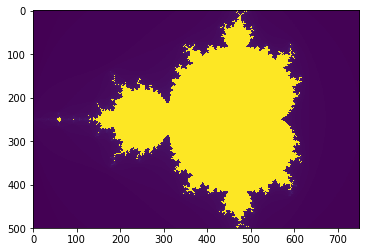

In [40]:
# these are some functions that calculate if a given complex number is part of the Mandlebrot set
# and visualizes the resulting fractal from trying every pixel coordinate
# here's the unmodified functions and an estimate of their performance
# example taken from the Numba docs: http://numba.pydata.org/numba-doc/0.15.1/examples.html

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500, 750), dtype=np.uint8)
%timeit create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
plt.imshow(create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20))
plt.show()

10.9 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


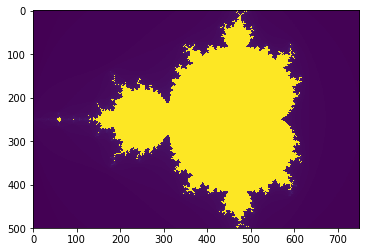

In [41]:
# here are the exact same functions but with the numba decorators on top
# spoiler alert - it's way faster

@numba.jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@numba.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500, 750), dtype=np.uint8)
%timeit create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
plt.imshow(create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20))
plt.show()

## Manage your memory
The biggest offenders of memory problems in Pandas are probably
* You have references still attached to variables, which means they don't get garbage collected
    * You have too many copies of DataFrames lying around
    * You could stand to do more in-place operations, which don't produce copies of your DataFrame
* `object` dtypes take up a lot more memory than fixed dtypes

### Garbage collection
Garbage collection is the process by which Python frees up memory by releasing memory that is no longer useful to program. You can release the objects referenced by memory by removing the reference to that object. This flags the formerly referenced object for memory release.

The best way to let garbage collection help you manage memory is to wrap whatever you can into functions. Variables declared in functions are only scoped to the function, so when the function is finished running, they get discarded. On the other hand, global variables (like `large_copy`) are kept around until the Python process ends (i.e. this notebook kernel is shut down). Even if you `del` a variable, it just decreases the reference by 1, but if the reference count isn't 0, the object referenced isn't actually deleted. That's why global variables can screw up what you think your memory is holding onto. 

Just for fun, you can peek into what a variable's reference count is by using `sys.getrefcount(var_name)`.

In [42]:
# `foo` is a reference
foo = []

sys.getrefcount(foo) # this temporarily bumps it up to 2

2

In [43]:
# yet another global reference bumps it up again
# at this point, `del` will not garbage collect `foo` 
foo.append(foo)

sys.getrefcount(foo)

3

### `object` dtypes take up a lot of memory

It's those pesky `object` dtypes again! Not surprisingly, telling Pandas that you need to be able to store literally anything at any time somewhere means that it will pre-allocate a huge amount of initial memory for you for the thing you're storing. This is fine if you're storing something complex, but if you're storing something that could easily be represented more simply, you might want to see if you can change the dtype to something better for your situation.

In [44]:
large_copy = df_large.copy()

In [45]:
# there's a very nifty tool for seeing how much memory your DataFrames are using.
large_copy.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
day_of_week      7000 non-null object
booleans         7000 non-null bool
positive_ints    7000 non-null int64
mixed_ints       7000 non-null int64
lat1             7000 non-null float64
lon1             7000 non-null float64
lat2             7000 non-null float64
lon2             7000 non-null float64
dtypes: bool(1), float64(4), int64(2), object(1)
memory usage: 773.5 KB


In [46]:
# a common practice when conserving memory is "downcasting"
# like, if you know your integers don't need 64-bits, cast them down to 32-bits
large_copy["positive_ints"] = large_copy["positive_ints"].astype(np.int32)

large_copy.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
day_of_week      7000 non-null object
booleans         7000 non-null bool
positive_ints    7000 non-null int32
mixed_ints       7000 non-null int64
lat1             7000 non-null float64
lon1             7000 non-null float64
lat2             7000 non-null float64
lon2             7000 non-null float64
dtypes: bool(1), float64(4), int32(1), int64(1), object(1)
memory usage: 746.2 KB


In [47]:
# all `str` types are stored as `object` in Pandas because they can be any length
# you can downcast string columns to a fixed-length `str` type
# for example, this limits to 10 characters
large_copy["day_of_week"] = large_copy["day_of_week"].astype("|S10")

large_copy.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
day_of_week      7000 non-null object
booleans         7000 non-null bool
positive_ints    7000 non-null int32
mixed_ints       7000 non-null int64
lat1             7000 non-null float64
lon1             7000 non-null float64
lat2             7000 non-null float64
lon2             7000 non-null float64
dtypes: bool(1), float64(4), int32(1), int64(1), object(1)
memory usage: 636.8 KB


In [48]:
# but if you also know that there aren't many unique strings
# you might want to try casting to category for the highest savings of all
large_copy["day_of_week"] = large_copy["day_of_week"].astype("category")

large_copy.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
day_of_week      7000 non-null category
booleans         7000 non-null bool
positive_ints    7000 non-null int32
mixed_ints       7000 non-null int64
lat1             7000 non-null float64
lon1             7000 non-null float64
lat2             7000 non-null float64
lon2             7000 non-null float64
dtypes: bool(1), category(1), float64(4), int32(1), int64(1)
memory usage: 315.2 KB
